# TRABAJO FIN DE MASTER - ESTUDIOS ADICIONALES
# **Author**: Cristóbal León-Salas
# **Date**: 2025-11-28

# LIBRERIAS

Se cargan las siguietnes librerias:

-  pandas --> Para tablas de datos.
-  numpy --> para cálculos numéricos y para trabajar con matrices y vectores.
-  os --> Para trabajar con directorios, archivos, carpetas,...
-  json --> Para trabajar con datos en formato JSON
-  shap --> Para explicar las predicciones de modelos de machine learning mediante valores de contribución basados en teoría de juegos.
-  matplotlib --> Para hacer visualizaciones gráficas básicas.
-  seaborn --> Para gráficos estadísticos más profesionales y de fácil interpretación.
-  warnings --> Para evitar mensajes de advertencias
-  product -->  Para sacar todas las combinaciones posibles entre los elementos de dos o más lista
-  display --> Para sacar tablas con formato.
-  KNeighborsRegressor --> Para obtener pronóstico con K-vecinos
-  ExponentialSmoothing --> Para hacer predicciones con suavizados exponenciales (Holt-Winters)
-  folium --> Para representación georreferenciada
-  unicodedata --> Permite manejar caracteres Unicode, como letras con acentos, eñes, tildes, etc.
-  re --> Es la librería estándar de Python para trabajar con expresiones regulares. Se usa para encontrar o reemplazar patrones de texto.
-  StandardScaler --> Para el normalizado y escalado de las variables
-  PCA --> Para llevar a cabo la técnica de componentes principales
-  mean_absolute_error, mean_squared_error --> Para hallar las métricas de los modelos
-  LGBMRegressor --> Para aplicar modelo LGBM
-  XGBRegressor--> Para aplicar modelos XGBOOST
-  CatBoostRegressor --> Para ejecutar modelos CatBoost
-  Prophet --> Para aplciar modelos Prophet
-  itertools --> Para hacer iteraciones eficientes
-  adfuller --> Ejecuta el test de Dickey–Fuller aumentado (ADF), que sirve para verificar si una serie temporal es estacionaria o no.
-  plot_acf, plot_pacf --> Para sacar los gráficos ACF y PACF
-  import SARIMAX --> Para aplicar modelos SARIMA
-  LSTM --> Captura dependencias temporales largas en series temporales
-  Dense --> Transforma la salida de capas anteriores en predicciones o activaciones
-  Conv1D --> Detecta patrones locales o estacionales en series temporales
-  GlobalAveragePooling1D --> Resume la información de toda la secuencia para clasificación o regresión
-  InputLayer --> Útil para modelos más personalizados o cuando no se usa input_shape en la primera capa
-  EarlyStopping --> Permito que los modelos deep learning se paren cuando ndeja de mejorar la validación. Ayuda a mitigar el sobreajuste


In [1]:
import pandas as pd
import numpy as np
import os
import json
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product
from IPython.display import display
import folium
from ydata_profiling import ProfileReport
from skimpy import skim
import unicodedata
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from prophet import Prophet
import lightgbm as lgb
from openpyxl import load_workbook
from pathlib import Path
from statsmodels.tsa.arima.model import ARIMA
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, GlobalAveragePooling1D, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
import random

# Ignorar el SettingWithCopyWarning
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
sns.set()

# MAGNITUD 10 - PARTÍCULAS < 10 μm

## LECTURA DE DATOS

In [2]:
# ============================
# 1. CARGA Y RECONSTRUCCIÓN DEL ÍNDICE
# ============================

CARPETA_BASE = "08_ANALISIS_COMPLEMENTARIOS"
CARPETA_SUB = "01_PM10_SUR"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, CARPETA_SUB)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

df_pm10_sur = pd.read_parquet("07.01_df_pm10_sur.parquet")

print("Shape del DataFrame:", df_pm10_sur.shape)
print("Primeras filas originales:")
print(df_pm10_sur.head())

# Nº de observaciones
n_obs = len(df_pm10_sur)

# Índice mensual empezando en julio 2025
nuevo_indice = pd.date_range(start="2025-07-01", periods=n_obs, freq="MS")

# Asignamos el nuevo índice
df_pm10_sur = df_pm10_sur.copy()
df_pm10_sur.index = nuevo_indice
df_pm10_sur.index.name = "fecha"


Shape del DataFrame: (90, 1)
Primeras filas originales:
        pred
0  22.844713
1  22.579872
2  17.507538
3  16.715141
4  16.908699


In [3]:
df_pm10_sur

,pred
fecha,
2025-07-01,22.844713
2025-08-01,22.579872
2025-09-01,17.507538
2025-10-01,16.715141
2025-11-01,16.908699
...,...
2032-08-01,24.062908
2032-09-01,17.284348
2032-10-01,17.110588


## GRÁFICO TEMPORAL

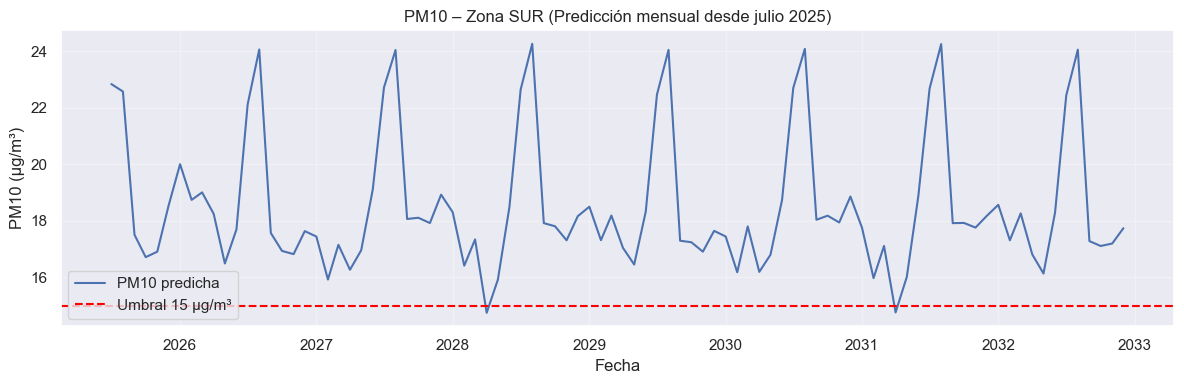

📁 Guardado: 08_ANALISIS_COMPLEMENTARIOS\01_PM10_SUR\01_serie_mensual_con_umbral.png


In [4]:
# ============================
# 2. GRÁFICO TEMPORAL + LÍNEA Y=15
# ============================
col_valor = "pred"

plt.figure(figsize=(12, 4))
plt.plot(df_pm10_sur.index, df_pm10_sur[col_valor], lw=1.5, label="PM10 predicha")
plt.axhline(y=15, color="red", linestyle="--", label="Umbral 15 µg/m³")

plt.title("PM10 – Zona SUR (Predicción mensual desde julio 2025)")
plt.xlabel("Fecha")
plt.ylabel("PM10 (µg/m³)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

ruta_linea = os.path.join(CARPETA_SALIDA, "01_serie_mensual_con_umbral.png")
plt.savefig(ruta_linea, dpi=150)
plt.show()
print(f"📁 Guardado: {ruta_linea}")


## BOXPLOT TRIMESTRAL

C:\Users\rosal\AppData\Local\Temp\ipykernel_23780\1359893900.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_trim = df_pm10_sur[col_valor].resample("Q").mean().to_frame(col_valor)


<Figure size 600x400 with 0 Axes>

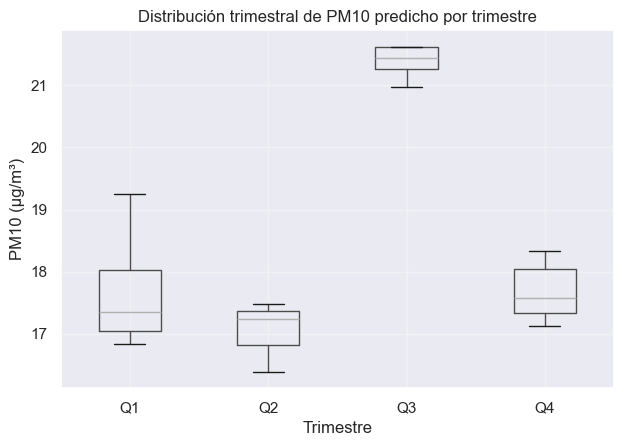

📁 Guardado: 08_ANALISIS_COMPLEMENTARIOS\01_PM10_SUR\02_boxplot_trimestral_Q1_Q4.png


In [5]:
#=============================================
# 3. PASO A TRIMESTRAL Y BOXPLOT POR Q1–Q4
# ============================================

df_trim = df_pm10_sur[col_valor].resample("Q").mean().to_frame(col_valor)
df_trim["quarter"] = df_trim.index.quarter
df_trim["quarter_cat"] = df_trim["quarter"].map({1: "Q1", 2: "Q2", 3: "Q3", 4: "Q4"})

plt.figure(figsize=(6, 4))
df_trim.boxplot(column=col_valor, by="quarter_cat")

plt.title("Distribución trimestral de PM10 predicho por trimestre")
plt.suptitle("")
plt.xlabel("Trimestre")
plt.ylabel("PM10 (µg/m³)")
plt.grid(alpha=0.3)
plt.tight_layout()

ruta_box = os.path.join(CARPETA_SALIDA, "02_boxplot_trimestral_Q1_Q4.png")
plt.savefig(ruta_box, dpi=150)
plt.show()
print(f"📁 Guardado: {ruta_box}")


## ESTUDIO DE LA VARIABILIDAD

In [6]:

# ============================================
# 4. ESTUDIO DE LA VARIABILIDAD DE LA SERIE
#    (escala diaria + trimestral)
# ============================================

serie_mensual = df_pm10_sur[col_valor]

stats = {
    "media_mensual": serie_mensual.mean(),
    "std_mensual": serie_mensual.std(),
    "cv_mensual": serie_mensual.std() / serie_mensual.mean(),
    "iqr_mensual": serie_mensual.quantile(0.75) - serie_mensual.quantile(0.25),

    "media_trimestral": df_trim[col_valor].mean(),
    "std_trimestral": df_trim[col_valor].std(),
    "cv_trimestral": df_trim[col_valor].std() / df_trim[col_valor].mean(),
    "iqr_trimestral": df_trim[col_valor].quantile(0.75) - df_trim[col_valor].quantile(0.25),
}

print("\n===== VARIABILIDAD DE LA SERIE (Mensual y Trimestral) =====")
for k, v in stats.items():
    print(f"{k}: {v:.3f}")


===== VARIABILIDAD DE LA SERIE (Mensual y Trimestral) =====
media_mensual: 18.526
std_mensual: 2.407
cv_mensual: 0.130
iqr_mensual: 1.632
media_trimestral: 18.526
std_trimestral: 1.853
cv_trimestral: 0.100
iqr_trimestral: 3.295


# MAGNITUD 8 - NO2

## LECTURA DE DATOS

In [7]:
# ============================
# 1. CARGA Y RECONSTRUCCIÓN DEL ÍNDICE
# ============================
CARPETA_SUB = "02_NO2_SUR"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, CARPETA_SUB)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

df_NO2_sur = pd.read_parquet("07.03_df_NO2_sur.parquet")

print("Shape del DataFrame:", df_NO2_sur.shape)
print("Primeras filas originales:")
print(df_NO2_sur.head())

# Nº de observaciones
n_obs = len(df_NO2_sur)

# Índice mensual empezando en julio 2025
nuevo_indice = pd.date_range(start="2025-07-01", periods=n_obs, freq="MS")

# Asignamos el nuevo índice
df_NO2_sur = df_NO2_sur.copy()
df_NO2_sur.index = nuevo_indice
df_NO2_sur.index.name = "fecha"

Shape del DataFrame: (90, 1)
Primeras filas originales:
        pred
0  16.742698
1  15.379871
2  24.319399
3  32.637161
4  32.259989


## GRÁFICO TEMPORAL

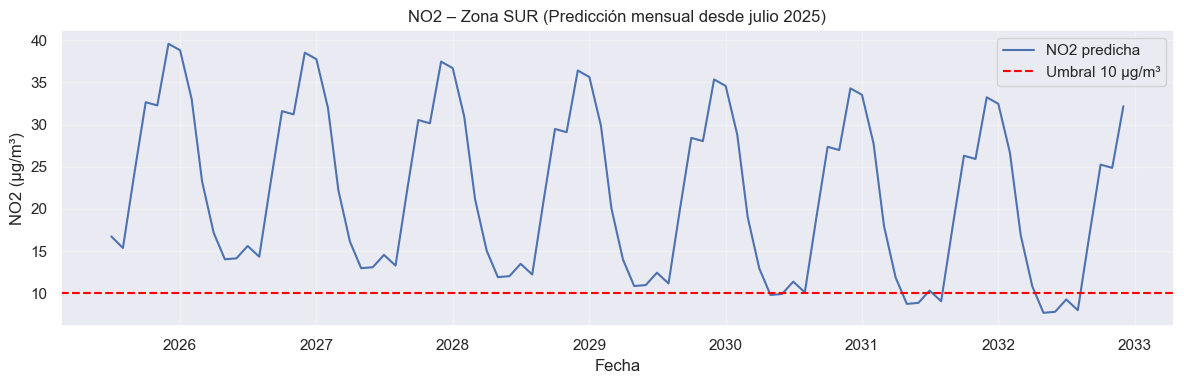

📁 Guardado: 08_ANALISIS_COMPLEMENTARIOS\02_NO2_SUR\01_serie_mensual_con_umbral.png


In [8]:
# ============================
# 2. GRÁFICO TEMPORAL + LÍNEA Y=10
# ============================
col_valor = "pred"

plt.figure(figsize=(12, 4))
plt.plot(df_NO2_sur.index, df_NO2_sur[col_valor], lw=1.5, label="NO2 predicha")
plt.axhline(y=10, color="red", linestyle="--", label="Umbral 10 µg/m³")

plt.title("NO2 – Zona SUR (Predicción mensual desde julio 2025)")
plt.xlabel("Fecha")
plt.ylabel("NO2 (µg/m³)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

ruta_linea = os.path.join(CARPETA_SALIDA, "01_serie_mensual_con_umbral.png")
plt.savefig(ruta_linea, dpi=150)
plt.show()
print(f"📁 Guardado: {ruta_linea}")


## GRÁFICA COMPARATIVA CON O3

In [9]:
df_O3_sur = pd.read_parquet("07.02_df_O3_sur.parquet")

print("Shape del DataFrame:", df_O3_sur.shape)
print("Primeras filas originales:")
print(df_O3_sur.head())

Shape del DataFrame: (90, 1)
Primeras filas originales:
        pred
0  82.156636
1  73.868834
2  57.433484
3  37.601262
4  30.742970


             NO2_pred    O3_pred
2025-07-01  16.742698  82.156636
2025-08-01  15.379871  73.868834
2025-09-01  24.319399  57.433484
2025-10-01  32.637161  37.601262
2025-11-01  32.259989  30.742970
             NO2_pred    O3_pred
2032-08-01   8.014818  83.775126
2032-09-01  16.917593  64.189706
2032-10-01  25.249641  42.456955
2032-11-01  24.866915  34.463697
2032-12-01  32.167985  25.707200


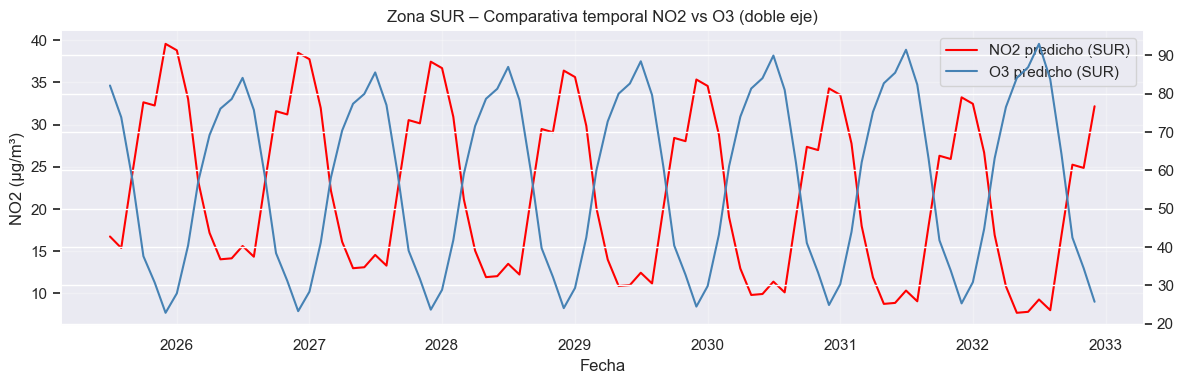

📁 Guardado: 08_ANALISIS_COMPLEMENTARIOS\02_NO2_SUR\02_comparativo_NO2_vs_O3_doble_eje.png


In [10]:
FECHA_INICIO = pd.to_datetime("2025-07-01")
n_periodos = len(df_NO2_sur)

idx_mensual = pd.date_range(start=FECHA_INICIO,
                            periods=n_periodos,
                            freq="MS")

# =========================================
# 2) DataFrame comparativo NO2 vs O3
# =========================================
df_cmp = pd.DataFrame({
    "NO2_pred": df_NO2_sur["pred"].values,
    "O3_pred":  df_O3_sur["pred"].values
}, index=idx_mensual)

print(df_cmp.head())
print(df_cmp.tail())

# =========================================
# 3) Gráfico con doble eje Y
# =========================================
fig, ax1 = plt.subplots(figsize=(12, 4))

# Eje izquierdo: NO2 (en rojo)
line1 = ax1.plot(
    df_cmp.index,
    df_cmp["NO2_pred"],
    lw=1.5,
    color="red",            # <<< CAMBIO SOLICITADO
    label="NO2 predicho (SUR)"
)
ax1.set_xlabel("Fecha")
ax1.set_ylabel("NO2 (µg/m³)")
ax1.grid(alpha=0.3)

# Eje derecho: O3
line2 = ax1.twinx().plot(
    df_cmp.index,
    df_cmp["O3_pred"],
    lw=1.5,
    linestyle="-",
    color="steelblue",      # color neutro para contraste
    label="O3 predicho (SUR)"
)

# Leyenda combinada
lines  = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right")

plt.title("Zona SUR – Comparativa temporal NO2 vs O3 (doble eje)")
plt.tight_layout()

ruta_cmp = os.path.join(CARPETA_SALIDA, "02_comparativo_NO2_vs_O3_doble_eje.png")
plt.savefig(ruta_cmp, dpi=150)
plt.show()
print(f"📁 Guardado: {ruta_cmp}")


# MAGNITUD 14 - O3

## LECTURA DE DATOS

In [11]:
# ============================
# 1. CARGA Y RECONSTRUCCIÓN DEL ÍNDICE
# ============================
CARPETA_SUB = "03_O3_SUR"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, CARPETA_SUB)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

df_O3_sur = pd.read_parquet("07.02_df_O3_sur.parquet")

print("Shape del DataFrame:", df_O3_sur.shape)
print("Primeras filas originales:")
print(df_O3_sur.head())

# Nº de observaciones
n_obs = len(df_O3_sur)

# Índice mensual empezando en julio 2025
nuevo_indice = pd.date_range(start="2025-07-01", periods=n_obs, freq="MS")

# Asignamos el nuevo índice
df_O3_sur = df_O3_sur.copy()
df_O3_sur.index = nuevo_indice
df_O3_sur.index.name = "fecha"

Shape del DataFrame: (90, 1)
Primeras filas originales:
        pred
0  82.156636
1  73.868834
2  57.433484
3  37.601262
4  30.742970


## GRÁFICO TEMPORAL

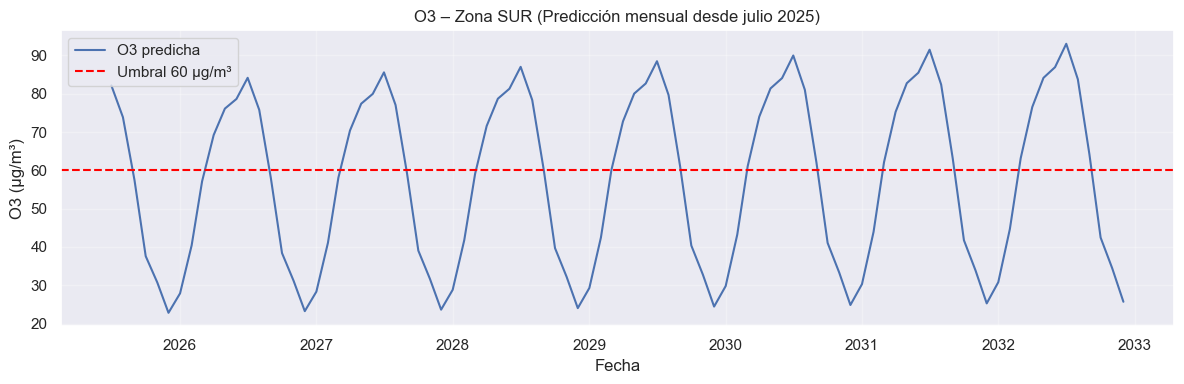

📁 Guardado: 08_ANALISIS_COMPLEMENTARIOS\03_O3_SUR\01_serie_mensual_con_umbral.png


In [12]:
# ============================
# 2. GRÁFICO TEMPORAL + LÍNEA Y=60
# ============================
col_valor = "pred"

plt.figure(figsize=(12, 4))
plt.plot(df_O3_sur.index, df_O3_sur[col_valor], lw=1.5, label="O3 predicha")
plt.axhline(y=60, color="red", linestyle="--", label="Umbral 60 µg/m³")

plt.title("O3 – Zona SUR (Predicción mensual desde julio 2025)")
plt.xlabel("Fecha")
plt.ylabel("O3 (µg/m³)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

ruta_linea = os.path.join(CARPETA_SALIDA, "01_serie_mensual_con_umbral.png")
plt.savefig(ruta_linea, dpi=150)
plt.show()
print(f"📁 Guardado: {ruta_linea}")


# MAGNITUD 9 - PARTÍCULAS < 2.5 μm

## LECTURA DE DATOS

In [13]:
# ============================
# 1. CARGA Y RECONSTRUCCIÓN DEL ÍNDICE
# ============================

CARPETA_SUB = "04_PM2_5_CENTRO"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, CARPETA_SUB)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

df_pm2_5_centro = pd.read_parquet("07.04_df_pm2_5_centro.parquet")

print("Shape del DataFrame:", df_pm2_5_centro.shape)
print("Primeras filas originales:")
print(df_pm2_5_centro.head())

# Nº de observaciones
n_obs = len(df_pm2_5_centro)

# Índice mensual empezando en julio 2025
nuevo_indice = pd.date_range(start="2025-07-01", periods=n_obs, freq="MS")

# Asignamos el nuevo índice
df_pm2_5_centro = df_pm2_5_centro.copy()
df_pm2_5_centro.index = nuevo_indice
df_pm2_5_centro.index.name = "fecha"

Shape del DataFrame: (90, 1)
Primeras filas originales:
        pred
0  10.593754
1  10.674342
2   8.812162
3   9.016570
4   8.131912


## GRÁFICO TEMPORAL

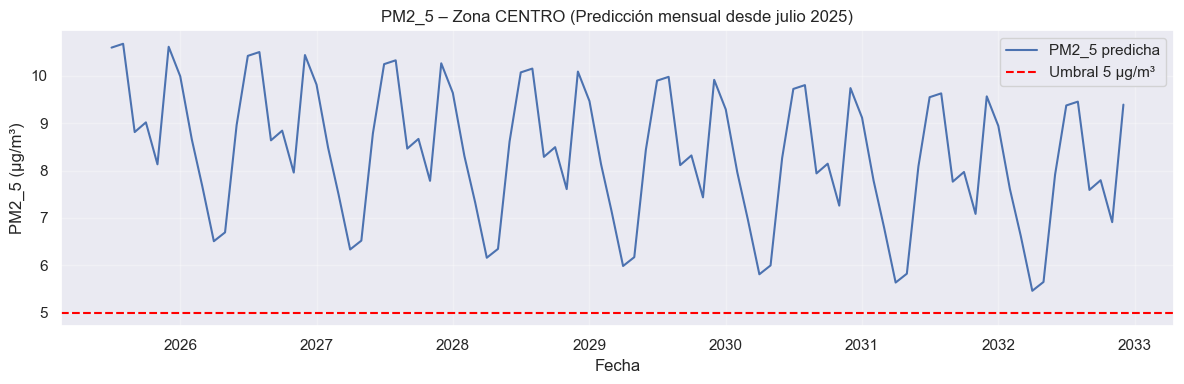

📁 Guardado: 08_ANALISIS_COMPLEMENTARIOS\04_PM2_5_CENTRO\01_serie_mensual_con_umbral.png


In [14]:
# ============================
# 2. GRÁFICO TEMPORAL + LÍNEA Y=60
# ============================
col_valor = "pred"

plt.figure(figsize=(12, 4))
plt.plot(df_pm2_5_centro.index, df_pm2_5_centro[col_valor], lw=1.5, label="PM2_5 predicha")
plt.axhline(y=5, color="red", linestyle="--", label="Umbral 5 µg/m³")

plt.title("PM2_5 – Zona CENTRO (Predicción mensual desde julio 2025)")
plt.xlabel("Fecha")
plt.ylabel("PM2_5 (µg/m³)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

ruta_linea = os.path.join(CARPETA_SALIDA, "01_serie_mensual_con_umbral.png")
plt.savefig(ruta_linea, dpi=150)
plt.show()
print(f"📁 Guardado: {ruta_linea}")

## BOXPLOT TRIMESTRAL

C:\Users\rosal\AppData\Local\Temp\ipykernel_23780\3917621109.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_trim = df_pm2_5_centro[col_valor].resample("Q").mean().to_frame(col_valor)


<Figure size 600x400 with 0 Axes>

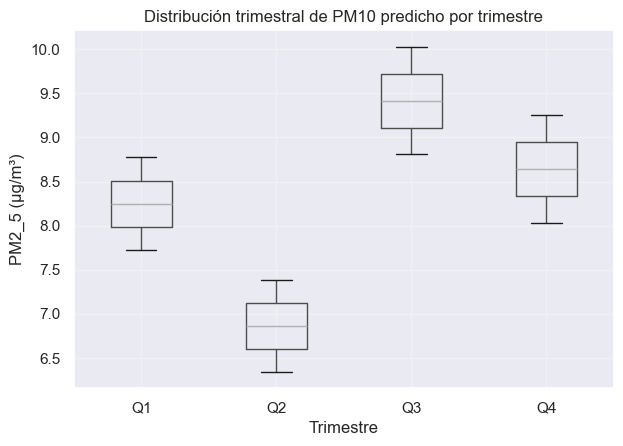

📁 Guardado: 08_ANALISIS_COMPLEMENTARIOS\04_PM2_5_CENTRO\02_boxplot_trimestral_Q1_Q4.png


In [15]:
#=============================================
# 3. PASO A TRIMESTRAL Y BOXPLOT POR Q1–Q4
# ============================================

df_trim = df_pm2_5_centro[col_valor].resample("Q").mean().to_frame(col_valor)
df_trim["quarter"] = df_trim.index.quarter
df_trim["quarter_cat"] = df_trim["quarter"].map({1: "Q1", 2: "Q2", 3: "Q3", 4: "Q4"})

plt.figure(figsize=(6, 4))
df_trim.boxplot(column=col_valor, by="quarter_cat")

plt.title("Distribución trimestral de PM10 predicho por trimestre")
plt.suptitle("")
plt.xlabel("Trimestre")
plt.ylabel("PM2_5 (µg/m³)")
plt.grid(alpha=0.3)
plt.tight_layout()

ruta_box = os.path.join(CARPETA_SALIDA, "02_boxplot_trimestral_Q1_Q4.png")
plt.savefig(ruta_box, dpi=150)
plt.show()
print(f"📁 Guardado: {ruta_box}")
